In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import json

In [2]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Utility function to display images
def show_images(images, title):
    img_grid = make_grid(images, nrow=8, normalize=True)
    np_img = img_grid.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation='nearest')
    plt.title(title)
    plt.show()

In [4]:
# Hyperparameters
img_size = 64  # Image size
img_channels = 1 #1 for Greyscale
latent_dim = 128  # Latent dimension for the generator
batch_size = 64
epochs = 150
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999
n_critic = 5  # Number of discriminator updates per generator update
lambda_gp = 10  # Gradient penalty lambda hyperparameter
nworkers = 8

In [5]:
# Data loading and preprocessing
data = np.load('norm-o-95.npy')

data = data.reshape(10046, 64, 64)
images_tensor = torch.FloatTensor(data).unsqueeze(1)  # Adding channel dimension
dataset = TensorDataset(images_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=nworkers, persistent_workers=True)

In [6]:
# DataLoader
dataset = TensorDataset(images_tensor)
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=nworkers, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=nworkers, persistent_workers=True)

In [7]:
# Define the Generator with CNN
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [8]:
# Define the Discriminator with Autoencoder using CNN
class DiscriminatorWithAutoencoder(nn.Module):
    def __init__(self, img_channels, img_size):
        super(DiscriminatorWithAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        ds_size = img_size // 2 ** 4
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, img_channels, 4, stride=2, padding=1)
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        encoded = self.encoder(img)
        encoded_flat = encoded.view(encoded.size(0), -1)
        validity = self.fc(encoded_flat)
        decoded = self.decoder(encoded)
        return validity, encoded, decoded

In [9]:
# Initialize models
generator = Generator(latent_dim, img_channels, img_size).cuda()
discriminator = DiscriminatorWithAutoencoder(img_channels, img_size).cuda()

In [10]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [11]:
# Loss functions
adversarial_loss = nn.BCELoss()
pixelwise_loss = nn.MSELoss()

In [12]:
# Define the gradient penalty function
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)[0]  # Extract first element
    fake = torch.ones(d_interpolates.shape, device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [13]:
# Define the loss functions
def discriminator_loss(real_images, fake_images, discriminator):
    real_validity = discriminator(real_images)[0]  # Extract first element
    fake_validity = discriminator(fake_images)[0]  # Extract first element
    gradient_penalty = compute_gradient_penalty(discriminator, real_images, fake_images)
    d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
    return d_loss, gradient_penalty.item()  # Return both loss and gradient penalty

In [14]:
def generator_loss(fake_images, discriminator):
    fake_validity = discriminator(fake_images)[0]  # Extract first element
    g_loss = -torch.mean(fake_validity)
    return g_loss

In [15]:
# Function to plot losses
def plot_losses(d_losses, g_losses, val_losses, gp_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.plot(gp_losses, label="Gradient Penalty")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator, Discriminator, Validation Loss, and Gradient Penalty per Epoch")
    plt.show()

In [16]:
# Function to save losses to a JSON file
def save_losses_to_json(d_losses, g_losses, val_losses, gp_losses, filename='losses-o.json'):
    losses = {
        'discriminator_loss': d_losses,
        'generator_loss': g_losses,
        'validation_loss': val_losses,
        'gradient_penalty': gp_losses
    }
    with open(filename, 'w') as f:
        json.dump(losses, f)

Epoch 68/150: 100%|██████████████████████████████████████████████████████████████████| 134/134 [01:23<00:00,  1.60it/s]


Epoch 75/150: 100%|██████████████████████████████████████████████████████████████████| 134/134 [01:23<00:00,  1.60it/s]


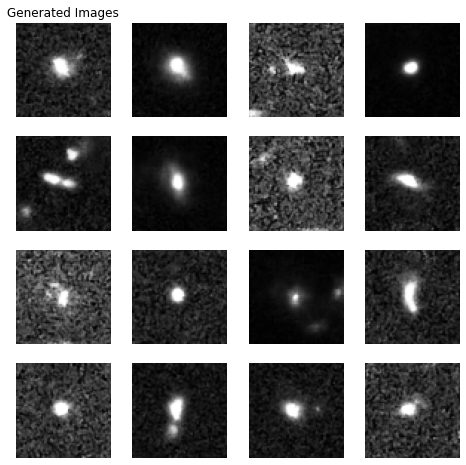

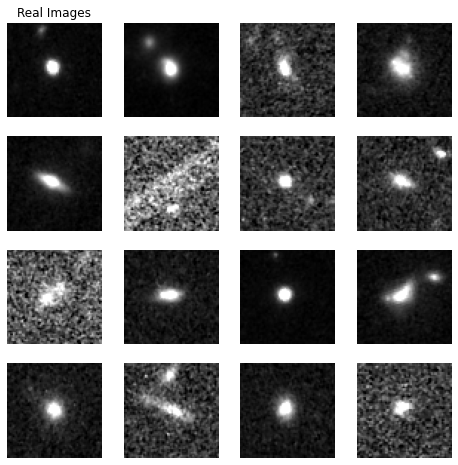

Epoch 112/150: 100%|█████████████████████████████████████████████████████████████████| 134/134 [01:23<00:00,  1.61it/s]


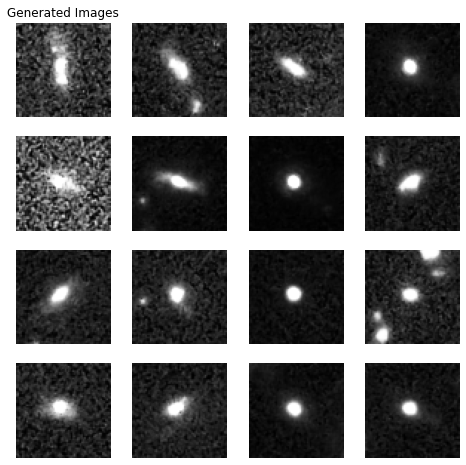

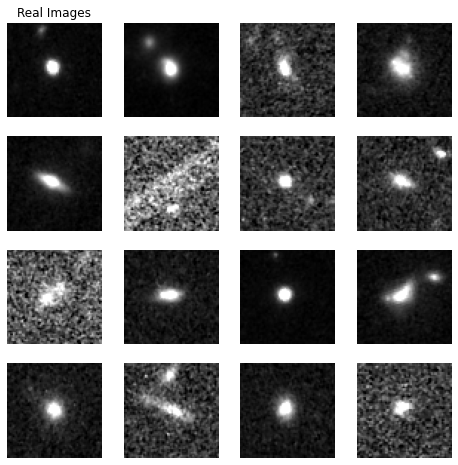

Epoch 150/150: 100%|█████████████████████████████████████████████████████████████████| 134/134 [01:23<00:00,  1.61it/s]


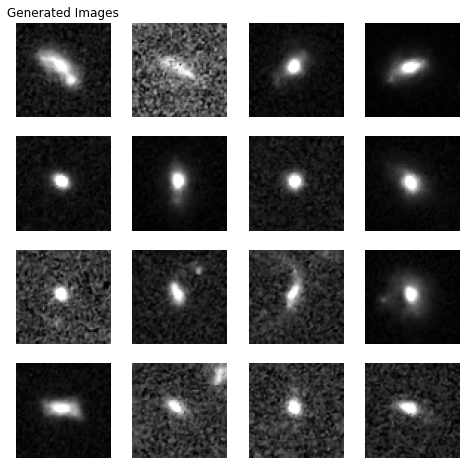

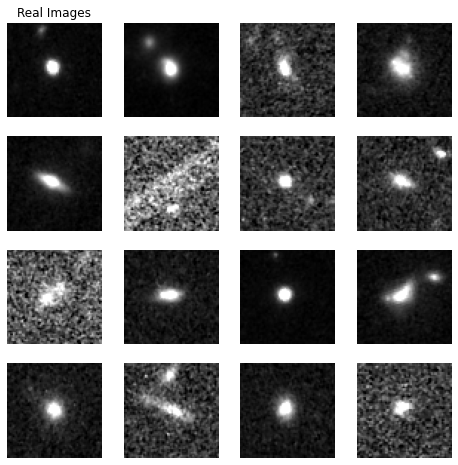

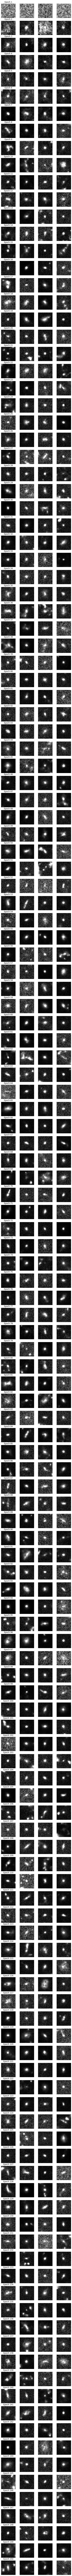

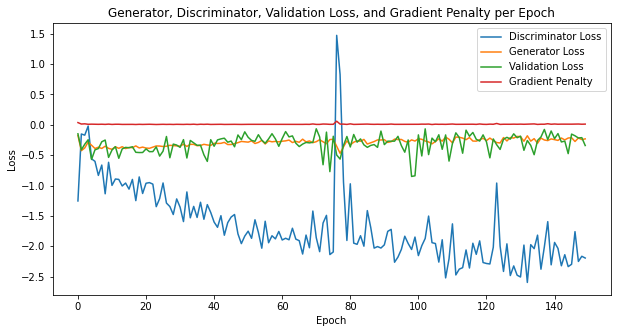

In [17]:
# Lists to store losses
d_losses = []
g_losses = []
val_losses = []
gp_losses = []

generated_samples = []

for epoch in range(epochs):
    d_loss_total = 0.0
    g_loss_total = 0.0
    gp_loss_total = 0.0
    epoch_samples = []

    for i, (real_imgs,) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")):
        batch_size_actual = real_imgs.size(0)
        real_imgs = real_imgs.cuda()

        # Train Discriminator
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            z = torch.randn(batch_size_actual, latent_dim).cuda()
            gen_imgs = generator(z)
            d_loss, gp_loss = discriminator_loss(real_imgs, gen_imgs.detach(), discriminator)
            d_loss.backward()
            optimizer_D.step()
            d_loss_total += d_loss.item()
            gp_loss_total += gp_loss

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_actual, latent_dim).cuda()
        gen_imgs = generator(z)
        g_loss = generator_loss(gen_imgs, discriminator)
        g_loss.backward()
        optimizer_G.step()
        g_loss_total += g_loss.item()
        epoch_samples.append(gen_imgs.detach().cpu().numpy())

    # Calculate average losses for the epoch
    d_losses.append(d_loss_total / len(train_dataloader))
    g_losses.append(g_loss_total / len(train_dataloader))
    gp_losses.append(gp_loss_total / (len(train_dataloader) * n_critic))
    generated_samples.append(epoch_samples)

    # Validation phase
    val_loss_total = 0.0
    with torch.no_grad():
        for real_imgs in val_dataloader:
            real_imgs = real_imgs[0].cuda()
            batch_size_actual = real_imgs.size(0)
            z = torch.randn(batch_size_actual, latent_dim).cuda()
            gen_imgs = generator(z)
            val_loss = generator_loss(gen_imgs, discriminator)
            val_loss_total += val_loss.item()

    val_losses.append(val_loss_total / len(val_dataloader))

    # Save generated images and compare real vs. fake
    samples = generator(torch.randn(16, latent_dim).cuda())
    samples = (samples + 1) / 2.0
    samples = samples.detach().cpu().numpy()

    if epoch == int(epochs * 0.5) - 1 or epoch == int(epochs * 0.75) - 1 or epoch == epochs - 1:
        # Plot generated images
        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        count = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(samples[count, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                count += 1
        axs[0, 0].set_title('Generated Images')

        # Plot real images
        real_samples = real_imgs[:16].detach().cpu().numpy()
        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        count = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(real_samples[count, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                count += 1
        axs[0, 0].set_title('Real Images')

        plt.show()
        
# Plot generated samples across epochs
fig, axs = plt.subplots(epochs, 4, figsize=(8, 2 * epochs))
for epoch in range(epochs):
    for i in range(4):
        axs[epoch, i].imshow(generated_samples[epoch][i][0, 0, :, :], cmap='gray')
        axs[epoch, i].axis('off')
        axs[epoch, 0].set_title(f'Epoch {epoch + 1}')

plt.show()

# Save losses to a JSON file
save_losses_to_json(d_losses, g_losses, val_losses, gp_losses)

# Call the function with the collected losses
plot_losses(d_losses, g_losses, val_losses, gp_losses)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Simple test model
model = nn.Linear(10, 1).to(device)
print("Model device:", next(model.parameters()).device)

# Simple test data
data = torch.randn(100, 10).to(device)
print("Data device:", data.device)

# Forward pass
output = model(data)
print("Output device:", output.device)


Using device: cuda
Model device: cuda:0
Data device: cuda:0
Output device: cuda:0


## Plotting from JSON

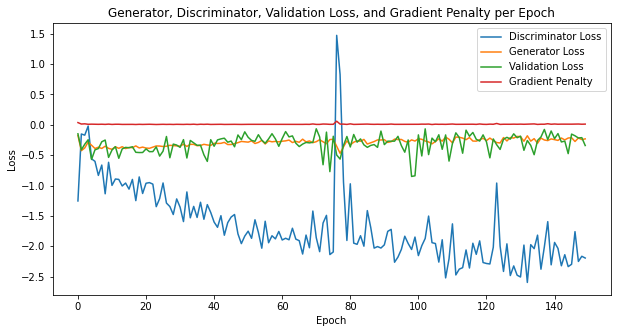

In [19]:
# Load the losses from the JSON file
with open('losses-o.json', 'r') as f:
    losses = json.load(f)

# Extract individual loss arrays
d_losses = losses['discriminator_loss']
g_losses = losses['generator_loss']
val_losses = losses['validation_loss']
gp_losses = losses['gradient_penalty']

# Plot the losses
plot_losses(d_losses, g_losses, val_losses, gp_losses)


In [20]:
# Save the final model
torch.save(generator.state_dict(), "generatorwithCNN-o.pth")
torch.save(discriminator.state_dict(), "discriminatorwithCNN-o.pth")